In [1]:
import dotenv
dotenv.load_dotenv()

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [47]:
from pydantic import BaseModel, Field
from typing import Literal
from langchain_core.tools import tool
from langchain_anthropic import ChatAnthropic
from langgraph.graph import MessagesState


class WeatherResponse(BaseModel):
    """Respond to the user with this"""

    temperature: float = Field(description="The temperature in fahrenheit")
    wind_directon: str = Field(
        description="The direction of the wind in abbreviated form"
    )
    wind_speed: float = Field(description="The speed of the wind in km/h")


# Inherit 'messages' key from MessagesState, which is a list of chat messages
class AgentState(MessagesState):
    # Final structured response from the agent
    final_response: WeatherResponse


@tool
def get_weather(city: Literal["nyc", "sf"]):
    """Use this to get weather information."""
    if city == "nyc":
        return "It is cloudy in NYC, with 5 mph winds in the North-East direction and a temperature of 70 degrees"
    elif city == "sf":
        return "It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction"
    else:
        raise AssertionError("Unknown city")


tools = [get_weather]

model = llm

model_with_tools = model.bind_tools(tools,strict=False)
model_with_structured_output = model.with_structured_output(WeatherResponse,strict=False)

In [48]:
model_with_structured_output.invoke("What is the weather in nyc?")

WeatherResponse(temperature=68.0, wind_directon='NW', wind_speed=15.0)

In [50]:
model_with_tools.invoke("What is the weather in nyc?It is 75 degrees and sunny in nyc, with 3 mph winds in the South-East direction")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Z1KcVTct0bCvwg26XdcXRyoK', 'function': {'arguments': '{"city":"nyc"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 80, 'total_tokens': 96, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-132cd763-7bf7-4191-8bb9-0008ac41df39-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'nyc'}, 'id': 'call_Z1KcVTct0bCvwg26XdcXRyoK', 'type': 'tool_call'}], usage_metadata={'input_tokens': 80, 'output_tokens': 16, 'total_tokens': 96, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

tools = [get_weather, WeatherResponse]

# Force the model to use tools by passing tool_choice="any"
model_with_response_tool = model.bind_tools(tools, tool_choice="any")


# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_response_tool.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    # Construct the final answer from the arguments of the last tool call
    weather_tool_call = state["messages"][-1].tool_calls[0]
    response = WeatherResponse(**weather_tool_call["args"])
    # Since we're using tool calling to return structured output,
    # we need to add  a tool message corresponding to the WeatherResponse tool call,
    # This is due to LLM providers' requirement that AI messages with tool calls
    # need to be followed by a tool message for each tool call
    tool_message = {
        "type": "tool",
        "content": "Here is your structured response",
        "tool_call_id": weather_tool_call["id"],
    }
    # We return the final answer
    return {"final_response": response, "messages": [tool_message]}


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is only one tool call and it is the response tool call we respond to the user
    if (
        len(last_message.tool_calls) == 1
        and last_message.tool_calls[0]["name"] == "WeatherResponse"
    ):
        return "respond"
    # Otherwise we will use the tool node again
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

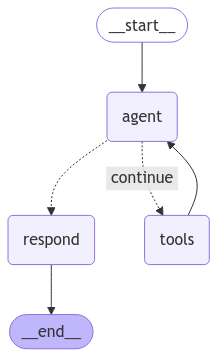

In [4]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})[
    "final_response"
]

In [7]:
type(answer)

__main__.WeatherResponse

In [8]:
answer

WeatherResponse(temperature=75.0, wind_directon='SE', wind_speed=3.0)

In [9]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?")]})

In [10]:
answer

{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='8356be89-9321-4b65-91ce-6c5897722b1f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0JjWJLaX3QPiiqrpXuAWSRJC', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 115, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7d928848-0725-4386-9be9-19363c451101-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_0JjWJLaX3QPiiqrpXuAWSRJC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 11

In [11]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in tokyo?")]})

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [12]:
answer

{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='8356be89-9321-4b65-91ce-6c5897722b1f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0JjWJLaX3QPiiqrpXuAWSRJC', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 115, 'total_tokens': 130, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7d928848-0725-4386-9be9-19363c451101-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_0JjWJLaX3QPiiqrpXuAWSRJC', 'type': 'tool_call'}], usage_metadata={'input_tokens': 11

In [17]:
model_with_structured_output.invoke("What is the weather in nyc?")

WeatherResponse(temperature=68.0, wind_directon='NW', wind_speed=15.0)

In [18]:
model_with_tools.invoke("What is the weather in nyc?")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Vspp9rtQNlAbYqL6dm2ZNx7l', 'function': {'arguments': '{"city":"nyc"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 59, 'total_tokens': 75, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-7fe848b3-17d5-4d63-9c98-a6a82b9ed534-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'nyc'}, 'id': 'call_Vspp9rtQNlAbYqL6dm2ZNx7l', 'type': 'tool_call'}], usage_metadata={'input_tokens': 59, 'output_tokens': 16, 'total_tokens': 75, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [33]:
tools

[StructuredTool(name='get_weather', description='Use this to get weather information.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x7ff12279b920>)]

In [42]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage


# Define the function that calls the model
def call_model(state: AgentState):
    response = model_with_tools.invoke(state["messages"])
    print("-----------------")
    # print(state["messages"])
    print(response)
    print("-----------------")
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# Define the function that responds to the user
def respond(state: AgentState):
    # We call the model with structured output in order to return the same format to the user every time
    # state['messages'][-2] is the last ToolMessage in the convo, which we convert to a HumanMessage for the model to use
    # We could also pass the entire chat history, but this saves tokens since all we care to structure is the output of the tool
    response = model_with_structured_output.invoke(
        [HumanMessage(content=state["messages"][-2].content)]
    )
    # We return the final answer
    return {"final_response": response}


# Define the function that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we respond to the user
    if not last_message.tool_calls:
        return "respond"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("respond", respond)
workflow.add_node("tools", ToolNode(tools))

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "tools",
        "respond": "respond",
    },
)

workflow.add_edge("tools", "agent")
workflow.add_edge("respond", END)
graph = workflow.compile()

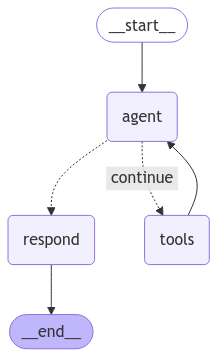

In [43]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [46]:
answer = graph.invoke(input={"messages": [("human", "what's the weather in SF?,It is 75 degrees and sunny in SF, with 3 mph winds in the South-East direction")]})

-----------------
content='' additional_kwargs={'tool_calls': [{'id': 'call_n8kjh0QcY2hgbKlOS4cAxxe4', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 78, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-96858949-6443-47df-a0b7-cbeca925dc25-0' tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_n8kjh0QcY2hgbKlOS4cAxxe4', 'type': 'tool_call'}] usage_metadata={'input_tokens': 78, 'output_tokens': 15, 'total_tokens': 93, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
--

In [45]:
answer

{'messages': [HumanMessage(content="what's the weather in SF?", additional_kwargs={}, response_metadata={}, id='c86d3ca5-975e-4da4-9585-daf6037d50c1'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_eQWGxc3P5Px9NCnmZAgnPlb6', 'function': {'arguments': '{"city":"sf"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 58, 'total_tokens': 73, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-643d8b22-32bc-453c-b07f-93ad5944be31-0', tool_calls=[{'name': 'get_weather', 'args': {'city': 'sf'}, 'id': 'call_eQWGxc3P5Px9NCnmZAgnPlb6', 'type': 'tool_call'}], usage_metadata={'input_tokens': 58, 